In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
pd.options.display.max_rows = 150
pd.options.display.max_columns = 150

In [2]:
df = pd.read_csv("data/data_merge.csv")

In [3]:
num_columns = [col for col in df.columns if df[col].dtype != "object"]
cat_columns = [col for col in df.columns if df[col].dtype == "object"]

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  StandardScaler,OneHotEncoder,FunctionTransformer
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

std = StandardScaler()
ohe= OneHotEncoder(sparse_output=False)

log_1p = FunctionTransformer(func=np.log1p)
preprocessor_pca = ColumnTransformer(
    transformers=[
        ("ohe",ohe,cat_columns),
        ("log",log_1p,num_columns)
    ]
    
)
tsne=Pipeline([
     ('preprocessor', preprocessor_pca),
     ('std', std ),
     ("tsne", TSNE(n_components=2,random_state=42,verbose=2,n_jobs=-1))
])

tsne_value = tsne.fit_transform(df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 92901 samples in 0.003s...
[t-SNE] Computed neighbors for 92901 samples in 16.851s...
[t-SNE] Computed conditional probabilities for sample 1000 / 92901
[t-SNE] Computed conditional probabilities for sample 2000 / 92901
[t-SNE] Computed conditional probabilities for sample 3000 / 92901
[t-SNE] Computed conditional probabilities for sample 4000 / 92901
[t-SNE] Computed conditional probabilities for sample 5000 / 92901
[t-SNE] Computed conditional probabilities for sample 6000 / 92901
[t-SNE] Computed conditional probabilities for sample 7000 / 92901
[t-SNE] Computed conditional probabilities for sample 8000 / 92901
[t-SNE] Computed conditional probabilities for sample 9000 / 92901
[t-SNE] Computed conditional probabilities for sample 10000 / 92901
[t-SNE] Computed conditional probabilities for sample 11000 / 92901
[t-SNE] Computed conditional probabilities for sample 12000 / 92901
[t-SNE] Computed conditional probabilities for sa

In [5]:
import pickle
pickle_out = open("tsne_com2.pkl", "wb") 
pickle.dump(tsne_value, pickle_out) 
pickle_out.close()
# pickle_in = open('tsne.pkl', 'rb') 
# tsne_value = pickle.load(pickle_in)

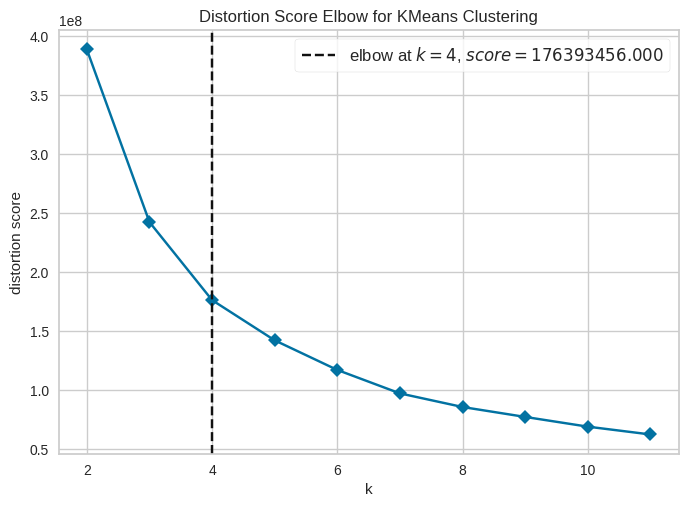

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(n_init=10,random_state=42),metric="distortion", k=(2,12),timings=False)

visualizer.fit(tsne_value)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [7]:
kmeans = KMeans(n_clusters=4,n_init=10,random_state=42)
kmeans.fit(tsne_value)

KMeans(n_clusters=6, n_init=10, random_state=42)

In [8]:
df["label"]=kmeans.labels_

{0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c', 3: '#d62728', 4: '#9467bd', 5: '#8c564b', 6: '#e377c2', 7: '#7f7f7f', 8: '#bcbd22', 9: '#17becf'}


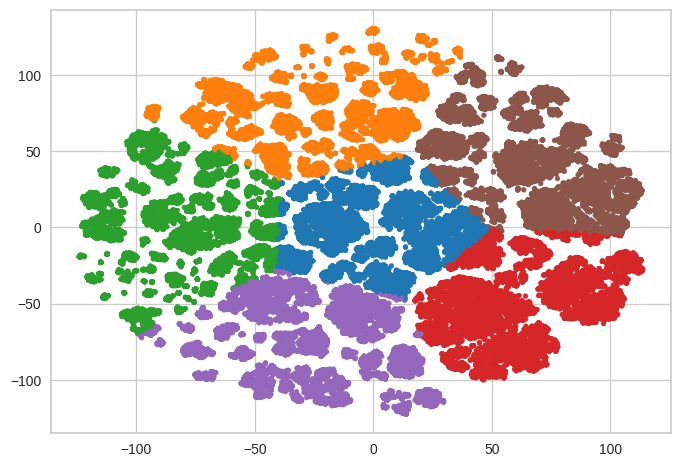

In [9]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.colors as mcolors


# Créer une liste de couleurs à partir de la palette "Set1" de Matplotlib
set1_colors = list(mcolors.TABLEAU_COLORS.values())[:10]

# Créer un dictionnaire pour mapper des couleurs aux valeurs de la liste
color_dict = {i: set1_colors[i] for i in range(len(set1_colors))}
print(color_dict)

plt.scatter(tsne_value[:,0],tsne_value[:,1],marker=".",c=[color_dict[i] for i in df["label"]])
plt.show()

In [10]:
result = df.groupby(['label']).mean()
result

/tmp/ipykernel_16565/825856455.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result = df.groupby(['label']).mean()


,nb_items_total,montant_total,nb_commande,mean_review_score,mean_payment_installments,mean_length_comment_title,mean_length_comment_message,mean_distance,recence,med_product_photos_qty,med_product_description_lenght
label,,,,,,,,,,,
0,1.104005,149.285867,1.000000,4.222905,3.205200,0.936826,29.454955,5.202667,306.574443,2.104462,956.538446
1,1.314727,200.093698,1.134683,4.064403,2.380084,2.021918,29.774867,5.453754,273.025977,2.374942,838.748018
2,1.197660,158.796694,1.011046,4.033325,1.341112,1.562139,30.069046,5.899824,289.750572,2.125270,854.550428
3,1.080557,183.002662,1.000000,4.236601,3.738879,0.003466,20.814686,6.027684,309.046601,2.248090,738.489056
4,1.057814,123.140992,1.000388,4.290690,2.680662,0.667972,17.896057,5.510089,298.001489,2.463615,619.102875
5,1.323922,177.006160,1.055361,3.915062,4.047364,2.909301,34.726303,5.432735,280.116319,2.009657,704.629329


In [11]:
import plotly.graph_objects as go

categories = result.columns
fig = go.Figure()

for g in result.index:
    fig.add_trace(go.Scatterpolar(
        r = result.loc[g].values,
        theta = categories,
        fill = 'toself',
        name = f'cluster #{g}'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5] # here we can define the range
    )),
  showlegend=True,
    title="Issues with Plotly",
    title_x=0.5
)

fig.show()

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  StandardScaler,FunctionTransformer
from sklearn.pipeline import Pipeline


std = StandardScaler()

log_1p = FunctionTransformer(func=np.log1p)
preprocessor_pca = ColumnTransformer(
    transformers=[
        ("log",log_1p,num_columns)
    ]
    
)
pipe=Pipeline([
     ('preprocessor', preprocessor_pca),
     ('std', std )
])



In [13]:
from kmodes.kprototypes import KPrototypes
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]

model_Kproto = KPrototypes(n_clusters=6, init="Cao", verbose=2, n_jobs=-1, n_init=8, random_state=42)
df_std = df.copy()
df_std[num_columns] = pipe.fit_transform(df[num_columns])
model_Kproto.fit_predict(df_std, categorical = catColumnsPos)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run: 1, iteration: 1/100, moves: 29078, ncost: 889336.1155955697
Run: 7, iteration: 1/100, moves: 28399, ncost: 873780.3569493832
Run: 8, iteration: 1/100, moves: 33462, ncost: 948422.0112950098
Run: 2, iteration: 1/100, moves: 31521, ncost: 885050.3507834056
Run: 6, iteration: 1/100

array([1, 5, 0, ..., 5, 1, 5], dtype=uint16)

In [14]:
# Add the cluster to the dataframe
df_kproto= df.copy()
df_kproto['label'] = model_Kproto.labels_

{0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c', 3: '#d62728', 4: '#9467bd', 5: '#8c564b', 6: '#e377c2', 7: '#7f7f7f', 8: '#bcbd22', 9: '#17becf'}


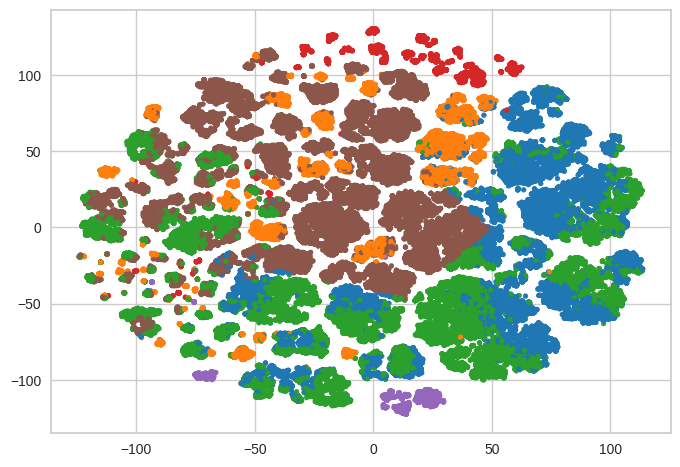

In [15]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.colors as mcolors


# Créer une liste de couleurs à partir de la palette "Set1" de Matplotlib
set1_colors = list(mcolors.TABLEAU_COLORS.values())[:10]

# Créer un dictionnaire pour mapper des couleurs aux valeurs de la liste
color_dict = {i: set1_colors[i] for i in range(len(set1_colors))}
print(color_dict)

plt.scatter(tsne_value[:,0],tsne_value[:,1],marker=".",c=[color_dict[i] for i in df_kproto["label"]])
plt.show()

In [16]:
result_kprot = df.groupby(['label']).mean()
result_kprot

/tmp/ipykernel_16565/3786504865.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,nb_items_total,montant_total,nb_commande,mean_review_score,mean_payment_installments,mean_length_comment_title,mean_length_comment_message,mean_distance,recence,med_product_photos_qty,med_product_description_lenght
label,,,,,,,,,,,
0,1.104005,149.285867,1.000000,4.222905,3.205200,0.936826,29.454955,5.202667,306.574443,2.104462,956.538446
1,1.314727,200.093698,1.134683,4.064403,2.380084,2.021918,29.774867,5.453754,273.025977,2.374942,838.748018
2,1.197660,158.796694,1.011046,4.033325,1.341112,1.562139,30.069046,5.899824,289.750572,2.125270,854.550428
3,1.080557,183.002662,1.000000,4.236601,3.738879,0.003466,20.814686,6.027684,309.046601,2.248090,738.489056
4,1.057814,123.140992,1.000388,4.290690,2.680662,0.667972,17.896057,5.510089,298.001489,2.463615,619.102875
5,1.323922,177.006160,1.055361,3.915062,4.047364,2.909301,34.726303,5.432735,280.116319,2.009657,704.629329


In [17]:
import plotly.graph_objects as go

categories = result_kprot.columns
fig = go.Figure()

for g in result_kprot.index:
    fig.add_trace(go.Scatterpolar(
        r = result_kprot.loc[g].values,
        theta = categories,
        fill = 'toself',
        name = f'cluster #{g}'
    ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5] # here we can define the range
    )),
  showlegend=True,
    title="Issues with Plotly",
    title_x=0.5
)

fig.show()